In [1]:
import numpy as np
from client_example import send_mat_file_request
import nibabel as nib
from scipy.io import savemat, loadmat
import matplotlib.pyplot as plt

In [2]:
def rotation_by_permutarion(im, angle):
    if angle == 90:
        im = im.T
    elif angle == -90:
        im = im.T
        im = im[::-1, :]
        return im
    elif angle == 180:
        im = im[:, :-1]
    return im


def vertical_plot_comp(images_list, rango=(-0.1, 0.1), rot=(0, 0, 0), fsize=5, return_img=False, images=(1, 1, 1)):
    sub_images = []
    for image in images_list:
        D, H, W = image.shape
        im1 = rotation_by_permutarion(image[D // 2, :, :], rot[0])
        im2 = rotation_by_permutarion(image[:, H // 2, :], rot[1])
        im3 = rotation_by_permutarion(image[:, :, W // 2], rot[2])
        max_width = np.max([im1.shape[1], im2.shape[1], im3.shape[1]])

        if im1.shape[1] < max_width:
            padding_width = max_width - im1.shape[1]
            pad_before = padding_width // 2
            pad_after = padding_width - pad_before
            im1 = np.pad(im1, ((0, 0), (pad_before, pad_after)), mode='constant', constant_values=0)
        rows_with_content = np.any(im1 != 0, axis=1)
        im1 = im1[rows_with_content]

        if im2.shape[1] < max_width:
            padding_width = max_width - im2.shape[1]
            pad_before = padding_width // 2
            pad_after = padding_width - pad_before
            im2 = np.pad(im2, ((0, 0), (pad_before, pad_after)), mode='constant', constant_values=0)
        rows_with_content = np.any(im2 != 0, axis=1)
        im2 = im2[rows_with_content]

        if im3.shape[1] < max_width:
            padding_width = max_width - im3.shape[1]
            pad_before = padding_width // 2
            pad_after = padding_width - pad_before
            im3 = np.pad(im3, ((0, 0), (pad_before, pad_after)), mode='constant', constant_values=0)
        rows_with_content = np.any(im3 != 0, axis=1)
        im3 = im3[rows_with_content]

        if np.sum(images) == 1:
            idx = np.argmax(images)
            im = im1 if idx == 0 else im2 if idx == 1 else im3
        elif np.sum(images) == 3:
            im = np.concatenate((im1, im2, im3), axis=0)
        else:
            _im = [x for x, i in zip([im1, im2, im3], images) if i == 1]
            im = np.concatenate(_im, axis=0)

        cols_with_content = np.any(im != 0, axis=0)
        im = im[:, cols_with_content]

        sub_images.append(im)
    im = np.concatenate(sub_images, axis=1)
    plt.figure(figsize=(fsize * len(images_list), 3 * fsize))
    plt.imshow(im, cmap='gray', vmin=rango[0], vmax=rango[1])
    plt.show()
    if return_img:
        return im


def rmse(gt, pred, mask):
    return 100 * np.linalg.norm(pred[mask == 1] - gt[mask == 1]) / np.linalg.norm(gt[mask == 1])

# 1. QSM challenge 2 sim2

In [3]:
B0 = 7
gyro = 42.58
ER = 4
TEv = np.asarray([4, 12, 20, 28]) * 1e-3
phs_scale = gyro * B0
voxel_size = [1, 1, 1]

sim2gt = nib.load('./Data/Sim2ChiGT.nii.gz').get_fdata()
mask = loadmat('./Data/mask_final.mat')['mask_final']
field = nib.load('./Data/Frequency.nii.gz').get_fdata()

phase_use = np.zeros((176, 208, 208))

phase_use[:164, :205, :205] = field*mask / phs_scale

savemat('./Data/Sim2.mat', {'phase': phase_use})

In [4]:
xqsm_result = send_mat_file_request('http://localhost:5002/predict', './Data/Sim2.mat')
xqsm_result = np.asarray(xqsm_result['result'])

Sending .mat file request to http://localhost:5002/predict...
File path: ./Data/Sim2.mat
------
http://localhost:5002/predict
------


In [5]:
rmse(sim2gt * mask, xqsm_result[:164, :205, :205] * mask, mask)

np.float64(77.28321276861058)

In [6]:
savemat('./Data/xQSM_recon.mat', {'xQSM_recon': xqsm_result[:164, :205, :205] * mask})

In [7]:
qsmnet_result = send_mat_file_request('http://localhost:5001/predict', './Data/Sim2.mat')
qsmnet_result = np.asarray(qsmnet_result['result'])

Sending .mat file request to http://localhost:5001/predict...
File path: ./Data/Sim2.mat
------
http://localhost:5001/predict
------


In [8]:
rmse(sim2gt * mask, qsmnet_result[:164, :205, :205] * mask, mask)

np.float64(65.23990381652591)

In [9]:
savemat('./Data/QSMnetp_recon.mat', {'QSMnetp_recon': qsmnet_result[:164, :205, :205] * mask})

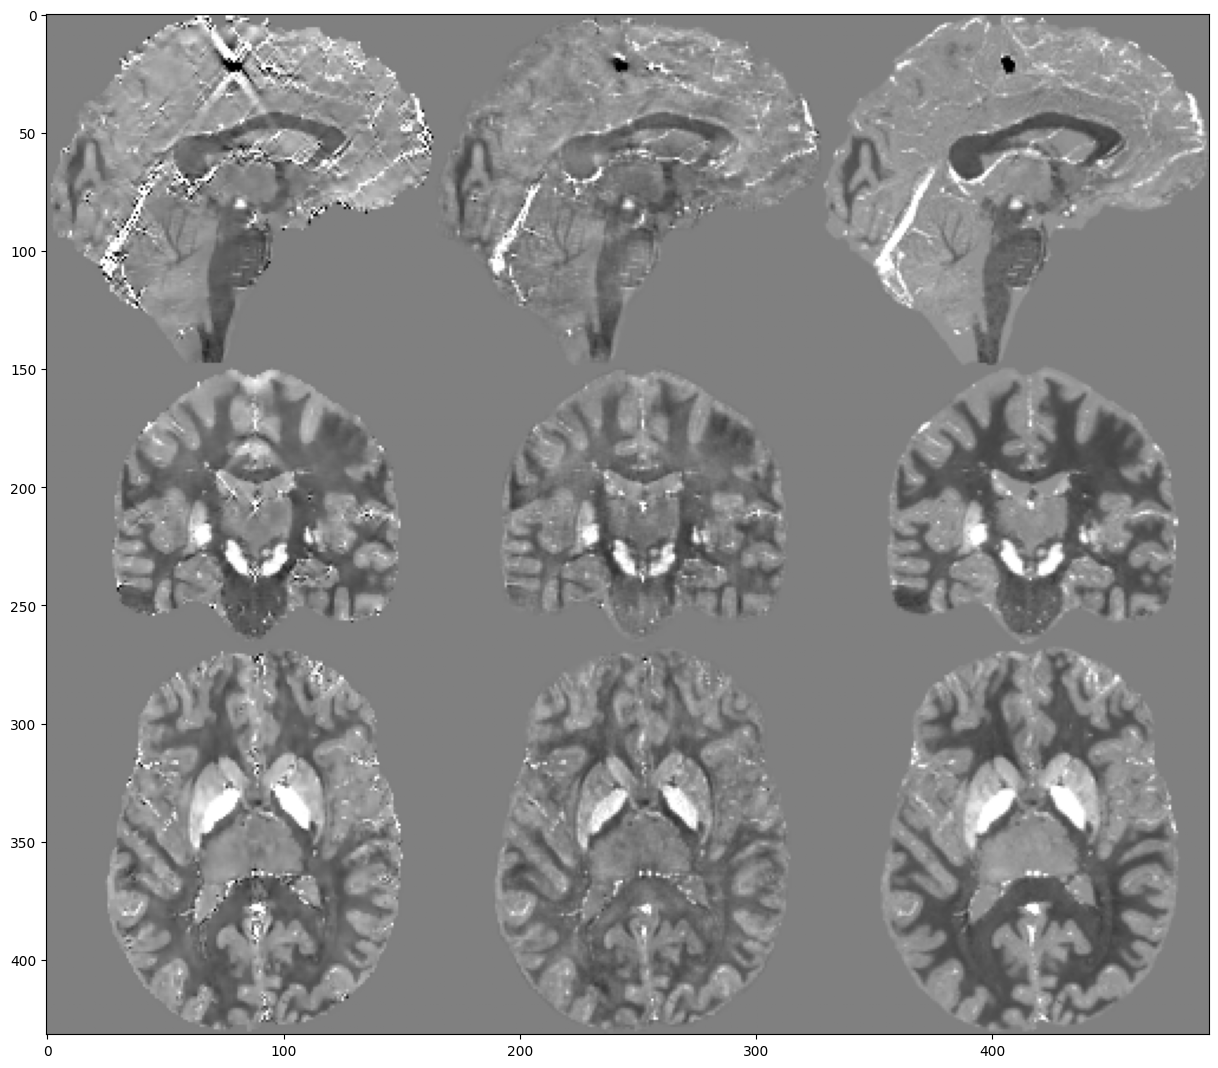

In [10]:
vertical_plot_comp([xqsm_result[:164, :205, :205] * mask, qsmnet_result[:164, :205, :205] * mask, sim2gt * mask], rot=(-90, -90, -90),
                   images=(1, 1, 1))
